# Unit-testing for Response Spectrum Generation Functions
*August 20th 2021*

**Aim**
- Generate test cases for the response_spectrum functions.
- Generate test case based on theoretical solution.
- Generate test case based on time integration of random time history from test-resources.
- Generate test case from SHAKE result (for step-by-step method).

In [65]:
# Standard library imports
import os
import sys
from itertools import product

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy.lib.recfunctions import structured_to_unstructured
from scipy.signal import resample

# Add project root to path
pkg_path = os.path.abspath("..")
if pkg_path not in sys.path:
    sys.path.insert(0, os.path.abspath(".."))

# Local application imports
import autoRS

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Useful Variables and Functions

In [70]:
# Get closest higher power of 2
def next_pwr_of_2(n):
    """Get the closest higher number that is a power of 2"""
    pwr = np.ceil(np.log(n)/np.log(2))
    return int(2**pwr)

# Hard low-pass filter
def low_pass_filter(signal, lp_frq, dt=0.005, time=None, zero_pad=True):
    """Function to low-pass filter a signal in the frequency domain
    by setting all fourier terms larger than `lp_freq` to 0.
    """
    if time is not None:
        dt = time[1]-time[0]
    if zero_pad:
        n = 2*next_pwr_of_2(len(signal))
    else:
        n = len(signal)
    frq = np.fft.rfftfreq(n, d=dt)
    signal_fft = np.fft.rfft(signal, n=n)
    lp_fft = signal_fft*(frq <= lp_frq)
    lp_signal = np.fft.irfft(lp_fft, n)[:len(signal)]
    return lp_signal

# Up-sample signal
def upsample(signal, time, multiplier):
    """Up-sample the signal. Multiply the number of points by multiplier."""
    num = multiplier*len(signal)
    up_signal = resample(signal, num)
    up_time = np.linspace(min(time), max(time), num=num, endpoint=True)
    return up_signal, up_time

## Import example time histories

- Import from `multi_col.csv`.
- Remove the last column which is filled with NaNs.
- Up-sample the THs. TH is is done to compare FFT and step methods. The step-by-step method becomes inaccurate if the TH sample rate is not sufficiently greater than the highest frequency content. Up-sampling ensures a fair comparison between the methods for unit-testing purposes.
- Alternative to up-sampling: Low-pass filter the THs at a frequency sufficiently lower than the sample rate to reduce the theoretical inaccuracy of the step-by-step method.

In [4]:
th_path = os.path.join("../tests", "test_resources", "multi_col.csv",)
th_raw = np.genfromtxt(
        th_path,
        delimiter=",",
        skip_header=1,
        names=True,
        deletechars=" !#$%&'()*+,-./:;<=>?[\\]^{|}~",
    )

# Convert to unstructured ndarray and remove nan values (last column)
th_raw = structured_to_unstructured(th_raw)
time = th_raw[:, 0]
th_arr = th_raw[:, 1:-1]

# Get number of THs
num_ths = th_arr.shape[1]
setnums = list(range(1, num_ths+1))

In [84]:
# Get upsampled THs to compare FFT and SHAKE methods
up_th_arr = []
for setnum in setnums:
    up_signal, up_time = upsample(th_arr[:, setnum-1], time, 4)
    up_th_arr.append(up_signal)
up_th_arr = np.array(up_th_arr).T

In [124]:
# Set up colormap
cmap = cm.get_cmap('viridis')
colors = [cmap(x) for x in np.linspace(0, 1, num=num_ths)]

# Pick test damping values
zeta_arr = np.linspace(0.01, 0.8, num=num_ths)

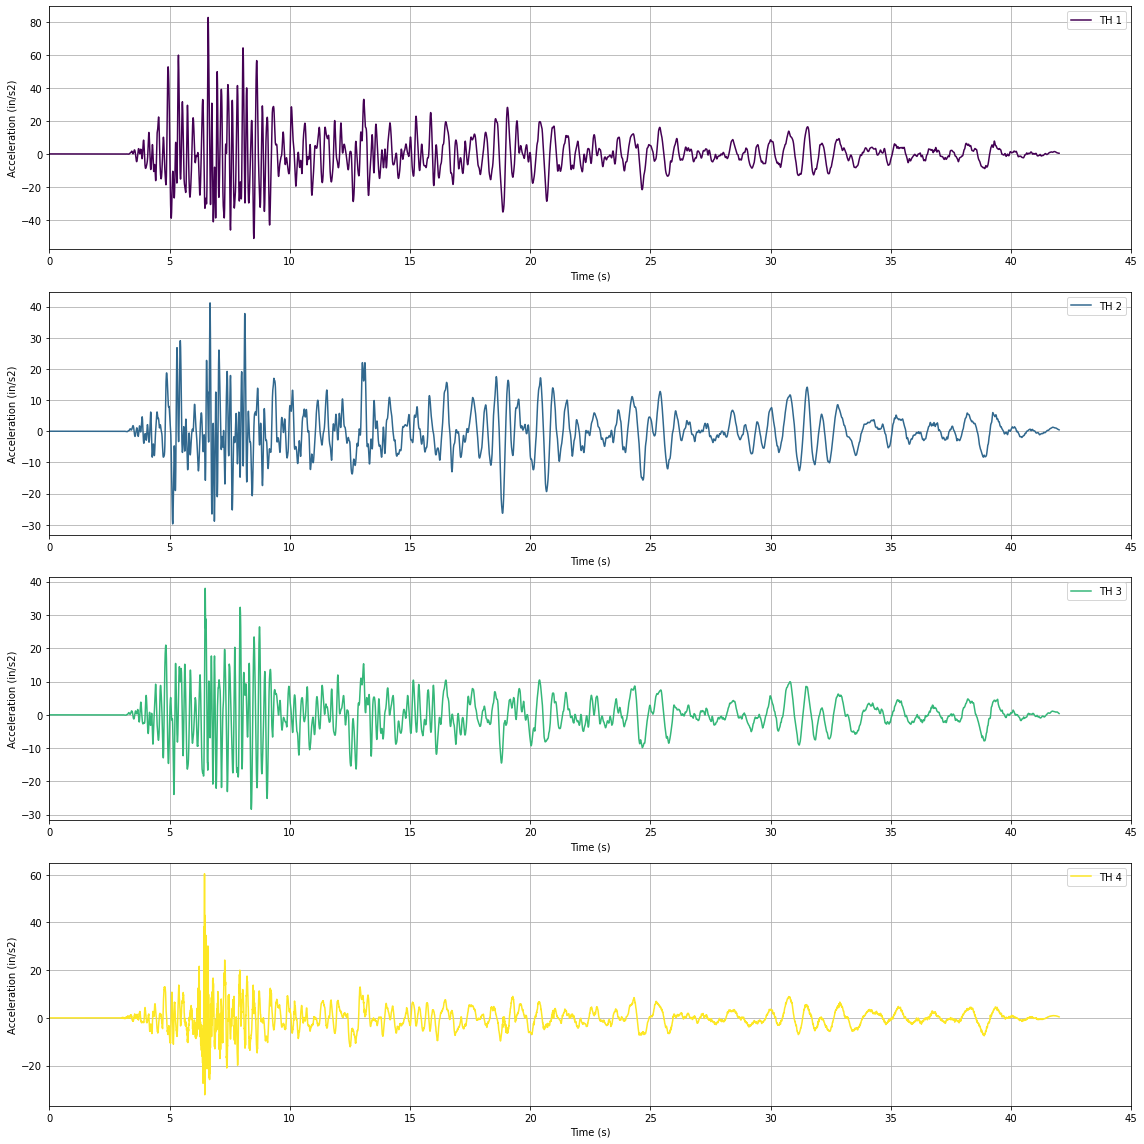

In [98]:
# Plot example THs
fig, axes = plt.subplots(nrows=num_ths, figsize=(16, 4*num_ths))
for setnum, ax, c in zip(setnums, axes, colors):
    ax.plot(time, th_arr[:, setnum-1], color=c, label=f"TH {setnum}")
    ax.grid(which='both')
    ax.legend()
    ax.set(
        xlim=(0, 45),
        xlabel="Time (s)",
        ylabel="Acceleration (in/s2)",
    )
plt.tight_layout()

## Test case comparing Shake and FFT methods

The Shake and FFT methods should give the same result provided that the time history (TH) sample rate is sufficiently greater (>5x) than the highest frequency content. So, when comparing the spectra for unit-tests, low-pass filter the THs first.

Since the example THs have been sampled at 200Hz, the low-pass frequency is taken as 200/8 = 25Hz.

In [94]:
lp_freq = 25

## Generate RS with all methods (low-pass and actual)

In [125]:
rs_dict = {}
lp_rs_dict = {}
for method in autoRS.RS_METHODS:
    rs_dict[method] = [
        autoRS.response_spectrum(
            th_arr[:, i], time, zeta=zeta_arr[i], method=method, high_frequency=False,
        )[0]
        for i in range(num_ths)
    ]
    
    lp_rs_dict[method] = [
        autoRS.response_spectrum(
            low_pass_filter(th_arr[:, i], lp_freq, time=time), 
            time, zeta=zeta_arr[i], method=method, high_frequency=False,
        )[0] 
        for i in range(num_ths)
    ]

frq = autoRS.spectrum.get_default_frequencies(high_frequency=False)

RS done. Time taken = 0.54696s 
time per iteration = 0.00547s
RS done. Time taken = 0.48938s 
time per iteration = 0.00489s
RS done. Time taken = 0.44995s 
time per iteration = 0.00450s
RS done. Time taken = 0.40057s 
time per iteration = 0.00401s
RS done. Time taken = 0.45945s 
time per iteration = 0.00459s
RS done. Time taken = 0.44727s 
time per iteration = 0.00447s
RS done. Time taken = 0.49188s 
time per iteration = 0.00492s
RS done. Time taken = 0.45135s 
time per iteration = 0.00451s
RS done. Time taken = 4.42533s 
time per iteration = 0.04425s
RS done. Time taken = 4.84625s 
time per iteration = 0.04846s
RS done. Time taken = 4.82670s 
time per iteration = 0.04827s
RS done. Time taken = 4.79967s 
time per iteration = 0.04800s
RS done. Time taken = 4.88911s 
time per iteration = 0.04889s
RS done. Time taken = 5.42317s 
time per iteration = 0.05423s
RS done. Time taken = 4.89962s 
time per iteration = 0.04900s
RS done. Time taken = 4.80517s 
time per iteration = 0.04805s


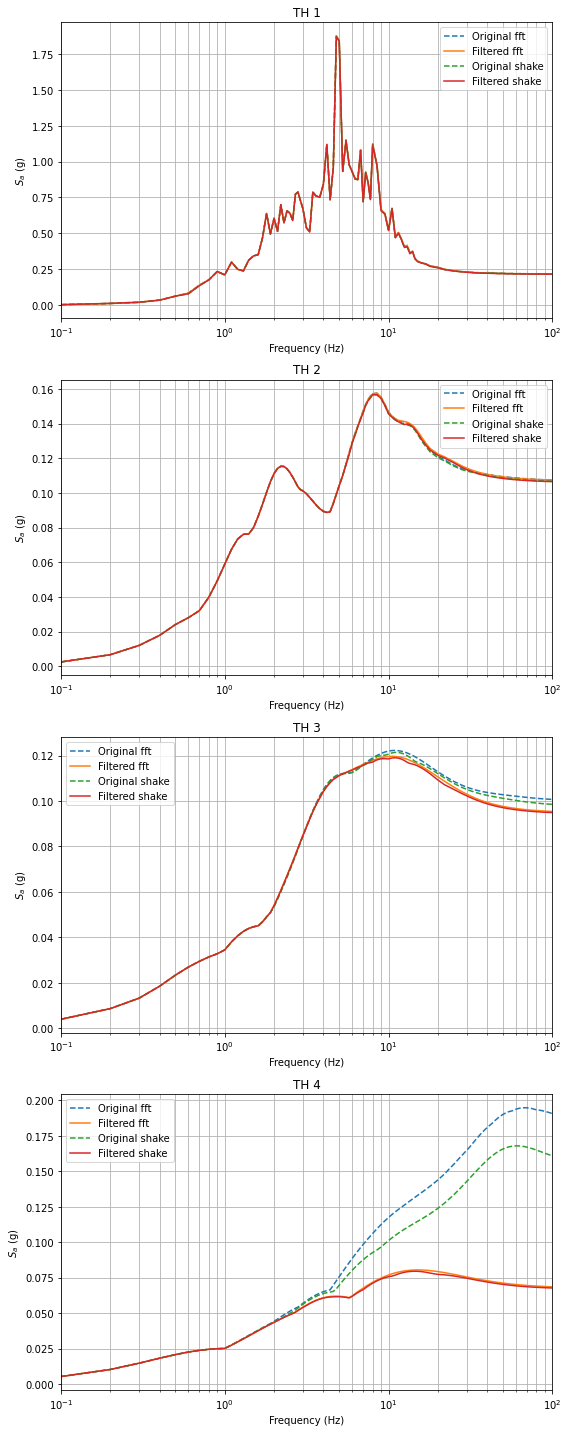

In [127]:
fig, axes = plt.subplots(nrows=num_ths, figsize=(8, 5*num_ths))

for setnum, ax in zip(setnums, axes):
    for method in autoRS.RS_METHODS:
        ax.semilogx(frq, rs_dict[method][setnum-1]/386.1, '--', label=f"Original {method}")
        ax.semilogx(frq, lp_rs_dict[method][setnum-1]/386.1, '-', label=f"Filtered {method}")
    ax.grid(which='both')
    ax.legend()
    _ = ax.set(
        xlim=(min(frq), max(frq)),
        xlabel="Frequency (Hz)",
        ylabel="$S_a$ (g)",
        title=f"TH {setnum}",
    )
plt.tight_layout()

### Possible Unit Tests

1. Ensure max. difference is less than 5%.
2. Ensure mean difference is less than 1%.

In [129]:
max_diffs = [
    np.quantile(np.absolute((lp_rs_dict["fft"][setnum-1]/lp_rs_dict["shake"][setnum-1]) - 1), 0.95)
    for setnum in setnums
]
print(max_diffs)

mean_diffs = [
    np.mean(np.absolute((lp_rs_dict["fft"][setnum-1]/lp_rs_dict["shake"][setnum-1]) - 1))
    for setnum in setnums
]
print(mean_diffs)

[0.023978845538721417, 0.008661309555850505, 0.009590293733734588, 0.018576031833897794]
[0.009826969077825211, 0.004472314229868133, 0.004140007776802941, 0.008597628394259675]


In [130]:
print("1) Results check max: ", all([diff < 0.05 for diff in max_diffs]))
print("2) Results check mean: ", all([diff < 0.01 for diff in mean_diffs]))

1) Results check max:  True
2) Results check mean:  True


## Test case using Theoretical solutions